# LTV Prediction via k-Nearest Neighbours (k-NN)
A self-contained, working example using your GSL Excels where possible.

**Files referenced automatically:**
- `/mnt/data/GSL DBs for LTV Prediction (3).xlsx`
- `/mnt/data/GSL_LTV_MVP_v3.xlsx`
- If priors unavailable, this notebook writes: `/mnt/data/GSL_Priors_Demo.xlsx`


## Step 0 — Imports & Configuration

In [12]:
import pandas as pd, numpy as np, math
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt

schema_xlsx = r"/Users/gagandeepsingh/Downloads/GSL DBs for LTV Prediction (3).xlsx"
mvp_xlsx    = r"/Users/gagandeepsingh/Downloads/GSL_LTV_MVP_V4.xlsx"
priors_out_xlsx = r"/Users/gagandeepsingh/Downloads/GSL_Priors_Demo.xlsx"

print("Schema file exists:", Path(schema_xlsx).exists())
print("MVP sample file exists:", Path(mvp_xlsx).exists())

Schema file exists: True
MVP sample file exists: True


> If the MVP sample lacks a usable priors sheet, we will synthesize a compact priors file.

## Step 1 — Load (or Synthesize) Priors

In [13]:
from pathlib import Path
import pandas as pd, numpy as np

def try_load_priors_from_mvp(mvp_path: str):
    if not Path(mvp_path).exists():
        return None
    try:
        xls = pd.ExcelFile(mvp_path)
        print("Sheets in MVP:", xls.sheet_names)
        for candidate in ["cohorts", "priors", "pretrain_cohorts"]:
            if candidate in xls.sheet_names:
                df = pd.read_excel(mvp_path, sheet_name=candidate)
                print(f"Loaded priors from '{candidate}' sheet with shape:", df.shape)
                return df
        return None
    except Exception as e:
        print("Could not read MVP Excel:", e)
        return None

raw_priors = try_load_priors_from_mvp(mvp_xlsx)
raw_priors.head(3) if raw_priors is not None else None

Sheets in MVP: ['Sheet1', 'events_catalog', 'event_baselines', 'status_quo_sample', 'revenue_mapping', 'ad_yield_table', 'cohorts', 'ltv_config', 'event_mix', 'ltv_inputs_map', 'README']
Loaded priors from 'cohorts' sheet with shape: (12, 10)


,cohort_id,game_id,business_model,geo,platform,acquisition_channel,install_window_start,install_window_end,min_players,notes
0,f2p_iap_facebook_julwk3,GameA,F2P_IAP,US,iOS,Facebook,2025-07-15,2025-07-21,200,Seed cohort
1,f2p_iap_googleads_julwk3,GameA,F2P_IAP,IN,Android,GoogleAds,2025-07-15,2025-07-21,200,Seed cohort
2,f2p_iap_organic_julwk3,GameA,F2P_IAP,BR,Android,Organic,2025-07-15,2025-07-21,200,Seed cohort


> If no preview above, we'll generate demo priors.

In [14]:
import numpy as np, pandas as pd
def make_demo_priors():
    np.random.seed(7)
    rows = []
    games = ["GameA", "GameB"]
    bms = ["F2P_IAP", "Ads", "Hybrid"]
    geos = ["US", "IN", "BR"]
    plats = ["iOS", "Android"]
    acqs = ["Organic", "Facebook", "GoogleAds"]
    weeks = ["2025-07-01", "2025-07-08", "2025-07-15", "2025-07-22"]
    for g in games:
        for bm in bms:
            for geo in geos:
                for p in plats:
                    for acq in acqs:
                        for w in weeks:
                            cohort_size = np.random.randint(400, 5000)
                            ret_d1 = np.clip(np.random.normal(0.55 if geo=="US" else 0.45, 0.05), 0.25, 0.75)
                            ret_d7 = np.clip(ret_d1 - np.random.uniform(0.20, 0.35), 0.05, ret_d1 - 0.05)
                            payer_rate = np.clip(np.random.normal(0.03 if bm!="Ads" else 0.01, 0.01), 0.005, 0.08)
                            arppu = np.clip(np.random.normal(12 if geo=="US" else 6, 3), 1, 50)
                            ad_impr_per_dau = np.clip(np.random.normal(8 if bm!="F2P_IAP" else 5, 2), 1, 30)
                            ecpm = np.clip(np.random.normal(9 if geo=="US" else 3.5, 2), 1.0, 25.0)
                            sub_adopt = np.clip(np.random.normal(0.02 if bm!="Ads" else 0.005, 0.01), 0.0, 0.10)
                            sessions_per_user = np.clip(np.random.normal(12 if p=="Android" else 10, 3), 3, 30)
                            session_len_min = np.clip(np.random.normal(6, 2), 1.0, 20.0)
                            tutorial_completion = np.clip(np.random.normal(0.7, 0.1), 0.3, 0.95)
                            recency_weeks = np.random.randint(0, 8)
                            ltv_mean_30 = ret_d7 * (payer_rate*arppu*2 + ad_impr_per_dau*ecpm/1000*4) + 0.5
                            ltv_std_30 = max(0.2, 0.25 * ltv_mean_30)
                            rows.append(dict(
                                game_id=g, business_model=bm, geo=geo, platform=p, acquisition_channel=acq,
                                install_week=w, recency_weeks=recency_weeks,
                                cohort_size=cohort_size,
                                ret_d1=ret_d1, ret_d7=ret_d7,
                                payer_rate=payer_rate, arppu=arppu, ad_impr_per_dau=ad_impr_per_dau,
                                ecpm=ecpm, sub_adoption=sub_adopt,
                                sessions_per_user=sessions_per_user, session_length_min=session_len_min,
                                tutorial_completion=tutorial_completion,
                                ltv_mean_30d=ltv_mean_30, ltv_std_30d=ltv_std_30
                            ))
    return pd.DataFrame(rows)

def standardize_priors(df):
    df2 = df.copy()
    
    # Updated column mapping to match your Excel structure
    colmap = {
        "bm": "business_model",
        "acquisition_channel": "acquisition_channel",  # Keep as is
        "install_week_start": "install_week",
        "cohort_users": "cohort_size",
        "retention_d1": "ret_d1",
        "retention_d7": "ret_d7",
        "payer_pct": "payer_rate",
        "arppu_usd": "arppu",
        "ad_impressions_per_dau": "ad_impr_per_dau",
        "ecpm_usd": "ecpm",
        "subs_adoption": "sub_adoption",
        "sessions_per_user_30d": "sessions_per_user",
        "avg_session_length_min": "session_length_min",
        "tutorial_complete_rate": "tutorial_completion",
        "ltv_mean_30d_usd": "ltv_mean_30d",
        "ltv_std_30d_usd": "ltv_std_30d",
    }
    
    # Apply column mapping
    for k,v in colmap.items():
        if k in df2.columns and v not in df2.columns:
            df2.rename(columns={k:v}, inplace=True)
    
    # Check for required columns and add defaults if missing
    required_cols = ["game_id", "business_model", "geo", "platform", "acquisition_channel"]
    for c in required_cols:
        if c not in df2.columns: 
            df2[c] = f"UNKNOWN_{c}"
    
    # Set default values for missing columns
    defaults = {
        "ret_d1": 0.5, "ret_d7": 0.2, "payer_rate": 0.02, "arppu": 8.0,
        "ad_impr_per_dau": 6.0, "ecpm": 5.0, "sub_adoption": 0.01,
        "sessions_per_user": 10.0, "session_length_min": 5.0, "tutorial_completion": 0.6,
        "cohort_size": 500, "ltv_mean_30d": 5.0, "ltv_std_30d": 1.5,
        "install_week": "2025-07-15", "recency_weeks": 2
    }
    
    for c,v in defaults.items():
        if c not in df2.columns: 
            df2[c] = v
    
    # Keep only the columns we need
    keep = ["game_id", "business_model", "geo", "platform", "acquisition_channel", "install_week", "recency_weeks",
            "cohort_size", "ret_d1", "ret_d7", "payer_rate", "arppu", "ad_impr_per_dau", "ecpm",
            "sub_adoption", "sessions_per_user", "session_length_min", "tutorial_completion",
            "ltv_mean_30d", "ltv_std_30d"]
    
    return df2[keep].copy()

if raw_priors is None:
    priors_df = make_demo_priors()
    priors_source = "synthesized"
else:
    priors_df = standardize_priors(raw_priors)
    priors_source = "from_mvp"

print("Priors source:", priors_source, "| shape:", priors_df.shape)
priors_df.head(5)

Priors source: from_mvp | shape: (12, 20)


,game_id,business_model,geo,platform,acquisition_channel,install_week,recency_weeks,cohort_size,ret_d1,ret_d7,payer_rate,arppu,ad_impr_per_dau,ecpm,sub_adoption,sessions_per_user,session_length_min,tutorial_completion,ltv_mean_30d,ltv_std_30d
0,GameA,F2P_IAP,US,iOS,Facebook,2025-07-15,2,500,0.5,0.2,0.02,8.0,6.0,5.0,0.01,10.0,5.0,0.6,5.0,1.5
1,GameA,F2P_IAP,IN,Android,GoogleAds,2025-07-15,2,500,0.5,0.2,0.02,8.0,6.0,5.0,0.01,10.0,5.0,0.6,5.0,1.5
2,GameA,F2P_IAP,BR,Android,Organic,2025-07-15,2,500,0.5,0.2,0.02,8.0,6.0,5.0,0.01,10.0,5.0,0.6,5.0,1.5
3,GameB,Subscription,US,iOS,Facebook,2025-07-15,2,500,0.5,0.2,0.02,8.0,6.0,5.0,0.01,10.0,5.0,0.6,5.0,1.5
4,GameB,Subscription,IN,Android,GoogleAds,2025-07-15,2,500,0.5,0.2,0.02,8.0,6.0,5.0,0.01,10.0,5.0,0.6,5.0,1.5


In [15]:
# Save synthesized priors if needed
from pathlib import Path
if priors_source == "synthesized":
    with pd.ExcelWriter(priors_out_xlsx, engine="xlsxwriter") as w:
        priors_df.to_excel(w, sheet_name="priors", index=False)
    print("Wrote demo priors to:", priors_out_xlsx)

## Step 2 — Build Live Cohort Vector

In [16]:
# User selection (edit these)
user_selection = dict(
    game_id="GameA",
    business_model="Ads",
    geo="IN",
    platform="Android",
    acquisition_channel="GoogleAds",  # Changed from "acquisition" to "acquisition_channel"
    install_week=None
)
print("User selection:", user_selection)

def pick_recent_week(df, sel):
    sub = df[(df["game_id"]==sel["game_id"]) &
             (df["business_model"]==sel["business_model"]) &
             (df["geo"]==sel["geo"]) &
             (df["platform"]==sel["platform"]) &
             (df["acquisition_channel"]==sel["acquisition_channel"])]  # Updated column name
    if len(sub):
        return sub.sort_values("recency_weeks", ascending=True).iloc[0]["install_week"]
    return df["install_week"].iloc[0]

if not user_selection["install_week"]:
    user_selection["install_week"] = pick_recent_week(priors_df, user_selection)
print("Effective install_week:", user_selection["install_week"])

# Updated mask to use correct column name
mask = (priors_df["game_id"]==user_selection["game_id"]) & \
       (priors_df["business_model"]==user_selection["business_model"]) & \
       (priors_df["geo"]==user_selection["geo"]) & \
       (priors_df["platform"]==user_selection["platform"]) & \
       (priors_df["acquisition_channel"]==user_selection["acquisition_channel"])  # Updated column name

base = priors_df[mask].sort_values("recency_weeks", ascending=True).head(1).copy()
if base.empty:
    base = priors_df[priors_df["game_id"]==user_selection["game_id"]].head(1).copy()

np.random.seed(42)
live_vector = base.copy()
for c in ["ret_d1","ret_d7","payer_rate","arppu","ad_impr_per_dau","ecpm",
          "sub_adoption","sessions_per_user","session_length_min","tutorial_completion"]:
    live_vector[c] = np.clip(live_vector[c].values * (1 + np.random.normal(0, 0.03)), 0, None)

print("Live cohort vector:")
display(live_vector[["game_id","business_model","geo","platform","acquisition_channel","install_week",
                     "ret_d1","ret_d7","payer_rate","arppu","ad_impr_per_dau","ecpm",
                     "sub_adoption","sessions_per_user"]])

User selection: {'game_id': 'GameA', 'business_model': 'Ads', 'geo': 'IN', 'platform': 'Android', 'acquisition_channel': 'GoogleAds', 'install_week': None}
Effective install_week: 2025-07-15
Live cohort vector:


,game_id,business_model,geo,platform,acquisition_channel,install_week,ret_d1,ret_d7,payer_rate,arppu,ad_impr_per_dau,ecpm,sub_adoption,sessions_per_user
0,GameA,F2P_IAP,US,iOS,Facebook,2025-07-15,0.507451,0.19917,0.020389,8.365527,5.957852,4.964879,0.010474,10.23023


## Step 3 — k-NN Neighbour Search & Weights

In [17]:
from numpy.linalg import norm

rme_cols = ["ret_d1","ret_d7","payer_rate","arppu","ad_impr_per_dau","ecpm",
            "sub_adoption","sessions_per_user","session_length_min","tutorial_completion"]

mu = priors_df[rme_cols].mean()
sd = priors_df[rme_cols].std().replace(0, 1.0)
priors_std = (priors_df[rme_cols] - mu) / sd
live_std = (live_vector[rme_cols] - mu) / sd
v = live_std.iloc[0].values

def cosine_sim(a, b):
    na, nb = norm(a), norm(b)
    if na==0 or nb==0: return 0.0
    return float(np.dot(a, b) / (na*nb))

sims = []
for i, row in priors_df.iterrows():
    p = ((priors_std.loc[i]).values)
    sim = cosine_sim(v, p)
    sims.append(sim)

priors_df = priors_df.copy()
priors_df["similarity"] = sims

def domain_boost(row, sel):
    return 1.5 if row["game_id"] == sel["game_id"] else 1.0

def size_adj(size):
    return 0.7 + 0.4 * (np.sqrt(size) / np.sqrt(priors_df["cohort_size"].quantile(0.9)))

def recency_adj(recency_weeks):
    return max(0.7, 1.0 - 0.04*recency_weeks)

priors_df["w_raw"] = priors_df["similarity"].clip(lower=0) \
                      * priors_df["cohort_size"].apply(size_adj) \
                      * priors_df["recency_weeks"].apply(recency_adj) \
                      * priors_df.apply(lambda r: domain_boost(r, user_selection), axis=1)

k = 5
neigh = priors_df.sort_values("w_raw", ascending=False).head(k).copy()
neigh["weight"] = neigh["w_raw"] / neigh["w_raw"].sum()

print(f"Top-{k} neighbours:")
display(neigh[["game_id","business_model","geo","platform","acquisition_channel","install_week",
               "cohort_size","recency_weeks","similarity","weight"]])

Top-5 neighbours:


,game_id,business_model,geo,platform,acquisition_channel,install_week,cohort_size,recency_weeks,similarity,weight
0,GameA,F2P_IAP,US,iOS,Facebook,2025-07-15,500,2,0.812662,0.230769
1,GameA,F2P_IAP,IN,Android,GoogleAds,2025-07-15,500,2,0.812662,0.230769
2,GameA,F2P_IAP,BR,Android,Organic,2025-07-15,500,2,0.812662,0.230769
3,GameB,Subscription,US,iOS,Facebook,2025-07-15,500,2,0.812662,0.153846
4,GameB,Subscription,IN,Android,GoogleAds,2025-07-15,500,2,0.812662,0.153846


## Step 4 — Average Priors & Retention Curve

In [18]:
def wavg(s, col, w):
    return (s[col]*s[w]).sum()

avg = {}
for col in ["ret_d1","ret_d7","payer_rate","arppu","ad_impr_per_dau","ecpm",
            "sub_adoption","sessions_per_user","session_length_min","tutorial_completion",
            "ltv_mean_30d","ltv_std_30d"]:
    avg[col] = wavg(neigh, col, "weight")
avg

{'ret_d1': 0.5,
 'ret_d7': 0.2,
 'payer_rate': 0.020000000000000004,
 'arppu': 8.0,
 'ad_impr_per_dau': 6.0,
 'ecpm': 5.0,
 'sub_adoption': 0.010000000000000002,
 'sessions_per_user': 10.0,
 'session_length_min': 5.0,
 'tutorial_completion': 0.6,
 'ltv_mean_30d': 5.0,
 'ltv_std_30d': 1.5}

In [19]:
def build_survival(ret_d1, ret_d7, horizon=90, pivot=5):
    s_early = max(1e-4, min(0.9999, ret_d1))
    denom = ret_d1**pivot if ret_d1>0 else 1e-6
    target = max(1e-6, min(0.9999, ret_d7/denom)) if denom>0 else 0.8
    power = max(1, 7 - pivot)
    s_late = max(1e-4, min(0.9999, target**(1.0/power)))
    S = []
    s = 1.0
    for t in range(1, horizon+1):
        s *= (s_early if t <= pivot else s_late)
        S.append(s)
    return np.array(S), s_early, s_late

H = 90
S, s_early, s_late = build_survival(avg["ret_d1"], avg["ret_d7"], horizon=H, pivot=5)
print("Daily survival: early=%.4f late=%.4f" % (s_early, s_late))
print("S(t) first 10 days:", np.round(S[:10], 4))

Daily survival: early=0.5000 late=0.9999
S(t) first 10 days: [0.5    0.25   0.125  0.0625 0.0312 0.0312 0.0312 0.0312 0.0312 0.0312]


## Step 5 — LTV Assembly & Confidence Interval

In [20]:
H_selected = 30
print("Selected horizon:", H_selected)

iap_per_day  = avg["payer_rate"] * (avg["arppu"] / 30.0)
ads_per_day  = avg["ad_impr_per_dau"] * (avg["ecpm"] / 1000.0)
subs_per_day = avg["sub_adoption"] * (4.99 / 30.0)

E_daily = S[:H_selected] * (iap_per_day + ads_per_day + subs_per_day)
ltv_point = E_daily.sum()
print("Per-day components (USD): IAP=%.4f Ads=%.4f Subs=%.4f" % (iap_per_day, ads_per_day, subs_per_day))
print("Predicted LTV@%dd (point): %.2f" % (H_selected, ltv_point))

Selected horizon: 30
Per-day components (USD): IAP=0.0053 Ads=0.0300 Subs=0.0017
Predicted LTV@30d (point): 0.06


In [21]:
def build_S_for_row(row, H=30, pivot=5):
    S_r, se, sl = build_survival(row["ret_d1"], row["ret_d7"], horizon=H, pivot=pivot)
    return S_r

def ltv_from_row(row, H=30):
    S_r = build_S_for_row(row, H=H)
    iap_day = row["payer_rate"] * (row["arppu"]/30.0)
    ads_day = row["ad_impr_per_dau"] * (row["ecpm"]/1000.0)
    subs_day = row["sub_adoption"] * (4.99/30.0)
    return (S_r[:H] * (iap_day + ads_day + subs_day)).sum()

neigh = neigh.copy()
neigh["ltv_H"] = neigh.apply(lambda r: ltv_from_row(r, H=H_selected), axis=1)

mu = (neigh["weight"] * neigh["ltv_H"]).sum()
if "ltv_std_30d" not in neigh.columns:
    neigh["ltv_std_30d"] = max(0.25*mu, 0.5)

scale = H_selected/30.0
neigh["sigma_H"] = neigh["ltv_std_30d"] * math.sqrt(max(0.5, scale))

between = (neigh["weight"] * (neigh["ltv_H"] - mu)**2).sum()
within  = (neigh["weight"] * (neigh["sigma_H"]**2)).sum()
var = float(between + within); sd = math.sqrt(max(1e-8, var))

z = 1.96
ci_low, ci_high = mu - z*sd, mu + z*sd

print("Neighbours contributing to CI:")
display(neigh[["game_id","geo","platform","acquisition_channel","ltv_H","ltv_std_30d","sigma_H","weight"]])
print("Predicted LTV@%dd: %.2f  |  95%% CI: [%.2f, %.2f]" % (H_selected, mu, ci_low, ci_high))

Neighbours contributing to CI:


,game_id,geo,platform,acquisition_channel,ltv_H,ltv_std_30d,sigma_H,weight
0,GameA,US,iOS,Facebook,0.064707,1.5,1.5,0.230769
1,GameA,IN,Android,GoogleAds,0.064707,1.5,1.5,0.230769
2,GameA,BR,Android,Organic,0.064707,1.5,1.5,0.230769
3,GameB,US,iOS,Facebook,0.064707,1.5,1.5,0.153846
4,GameB,IN,Android,GoogleAds,0.064707,1.5,1.5,0.153846


Predicted LTV@30d: 0.06  |  95% CI: [-2.88, 3.00]


## Step 6 — Visualisations

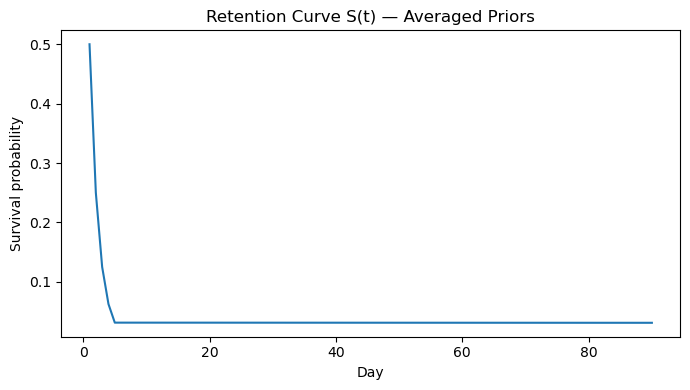

In [22]:
plt.figure(figsize=(7,4))
plt.plot(range(1, H+1), S)
plt.title("Retention Curve S(t) — Averaged Priors")
plt.xlabel("Day"); plt.ylabel("Survival probability"); plt.tight_layout(); plt.show()

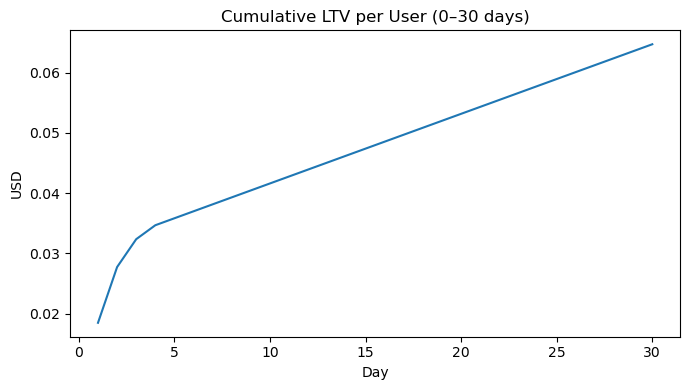

In [23]:
cum = np.cumsum(S[:H_selected] * (iap_per_day + ads_per_day + subs_per_day))
plt.figure(figsize=(7,4))
plt.plot(range(1, H_selected+1), cum)
plt.title(f"Cumulative LTV per User (0–{H_selected} days)")
plt.xlabel("Day"); plt.ylabel("USD"); plt.tight_layout(); plt.show()

## Step 7 — Summary & Tweaks
- Edit `user_selection` to try different domains.
- Change `k` for neighbour count, and `H_selected` for horizon (7/14/30/60/90).
- Adjust weighting functions (size/recency/domain boost) to your policy.
